The following methods will be adopted and compared in this project:

- Treat audio as images: convert audio to spectrogram (mel-spectrogram, power spectrogram etc), and forward to legacy CNNs for regression (1D or 2D)

- Raw audio inputs: load the audio as waveform via torchaudio.load(), and forward to different model architectures (e.g. CNN, Attention etc) for training

- Transfer learning: convert audio to embeddings via the PANN model (Large-Scale Pretrained Audio Neural Networks), and forward to different model architectures (e.g. BERT, Attention etc) for training

D:\venv\python\music-analysis\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


(-1.4998639455782312,
 31.497142857142855,
 -1.0996082484722138,
 1.0996082484722138)

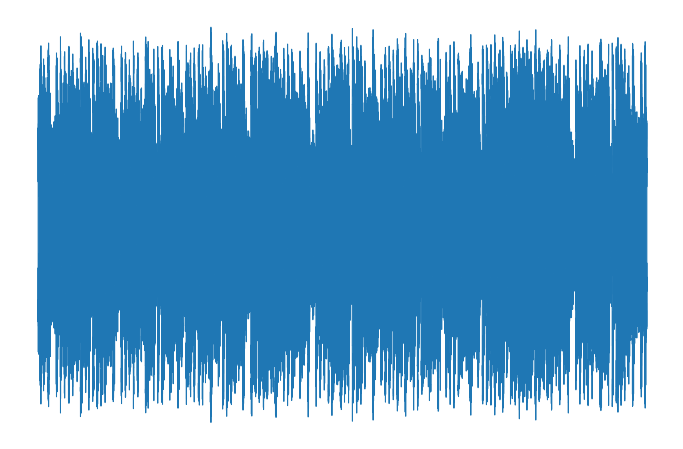

In [4]:
import librosa
import librosa.display as display
import matplotlib.pyplot as plt
import numpy as np

SAMPLE_FILE = r"D:\Documents\datasets\AIST4010\muse\songs\787Zn3STZNVI2q9DzKl9ka.mp3"
wavform, sr = librosa.load(SAMPLE_FILE, duration=30, mono=True)
# wavform_harm, wavform_perc = librosa.effects.hpss(wavform)

fig, axs = plt.subplots(1, 1, figsize=(12, 8))
librosa.display.waveshow(y=wavform, sr=sr, ax=axs)
# axs.set_title("wave plot")
axs.axis('off')
# mel_spec = librosa.feature.melspectrogram(y=wavform, sr=sr)
# powered_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
# librosa.display.specshow(powered_mel_spec, ax=axs[1], cmap="viridis")
# axs[1].set_title("mel-spec")
# axs[1].axis('off')

In [17]:
import glob
import os
import re
from PIL import Image


DATA_DIR = r"D:\Documents\datasets\AIST4010\muse"
PNG_DIR = os.path.join(DATA_DIR, "spectrograms")
SPEC_DIR = os.path.join(DATA_DIR, "spectrograms_jpg")
songs_data_fp = os.path.join(DATA_DIR, "extracted_data.csv")


PNG_FILES = glob.glob(os.path.join(PNG_DIR, '*'))
JPG_FILES = glob.glob(os.path.join(SPEC_DIR, '*'))
PNG_IDS = [re.match(r".*\\([^\.\\]*)\.png", fp).group(1) for fp in PNG_FILES]
JPG_IDS = [re.match(r".*\\([^\.\\]*)\.jpg", fp).group(1) for fp in JPG_FILES]

In [15]:
for fp in PNG_FILES[7350:]:
    img_id = re.match(r".*\\([^\.\\]*)\.png", fp).group(1)
    im1 = Image.open(fp).convert("RGB")
    im1.save(os.path.join(SPEC_DIR, img_id)+'.jpg')

In [19]:
for img_id in PNG_IDS:
    assert img_id in JPG_IDS

In [21]:
len(set(PNG_IDS)), len(set(JPG_IDS))

(10000, 10000)

In [2]:
import numpy as np


np.load(r"D:\Documents\datasets\AIST4010\muse\wavs\000xQL6tZNLJzIrtIgxqSl.npy")

array([0.05301074, 0.31244323, 0.4811889 , ..., 0.23341763, 0.2685385 ,
       0.3104872 ], dtype=float32)

In [69]:
import torch.nn as nn
from positional_encodings import PositionalEncoding2D
import torch

p_enc = PositionalEncoding1D(128)
z = torch.zeros(1, 128, 128)
pz = p_enc(z)
pz

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.8415,  0.7617,  0.6816,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.9093,  0.9870,  0.9975,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [-0.6160,  0.9903, -0.4891,  ...,  0.9998,  0.9999,  0.9999],
         [ 0.3300,  0.7475,  0.2366,  ...,  0.9998,  0.9999,  0.9999],
         [ 0.9726, -0.0217,  0.8354,  ...,  0.9998,  0.9999,  0.9999]]])

torch.Size([1, 128, 128])

In [67]:
pz

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.8415,  0.7617,  0.6816,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.9093,  0.9870,  0.9975,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [-0.6160,  0.9903, -0.4891,  ...,  0.9998,  0.9999,  0.9999],
         [ 0.3300,  0.7475,  0.2366,  ...,  0.9998,  0.9999,  0.9999],
         [ 0.9726, -0.0217,  0.8354,  ...,  0.9998,  0.9999,  0.9999]]])

In [88]:
import math
import torch


def positionalencoding1d(d_model, length):
    """
    :param d_model: dimension of the model
    :param length: length of positions
    :return: length*d_model position matrix
    """
    if d_model % 2 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dim (got dim={:d})".format(d_model))
    pe = torch.zeros(length, d_model)
    position = torch.arange(0, length).unsqueeze(1)
    div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                         -(math.log(10000.0) / d_model)))
    pe[:, 0::2] = torch.sin(position.float() * div_term)
    pe[:, 1::2] = torch.cos(position.float() * div_term)

    return pe

encodings = positionalencoding1d(128, 128)

In [74]:
data = torch.zeros(32, 3, 128, 128)

In [75]:
data.shape

torch.Size([32, 3, 128, 128])

In [98]:
torch.cat((encodings.repeat([32, 1, 1, 1]), data), dim=1).shape

torch.Size([32, 4, 128, 128])